<a href="https://colab.research.google.com/github/mbgu/hepatitisdatasetAIdeepNN/blob/main/hcvrcoklumodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
#https://github.com/JNYH/diabetes_classifier/blob/master/diabetes_classifier.ipynb
#https://towardsdatascience.com/building-a-machine-learning-classifier-model-for-diabetes-4fca624daed0
#Seabold, Skipper, and Josef Perktold. “statsmodels: Econometric and statistical modeling with python.”
#Proceedings of the 9th Python in Science Conference. 2010.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score
from sklearn.neural_network import MLPClassifier

SEED = 42

In [3]:
df = pd.read_csv('/content/drive/datafile/hcvr.csv')
df.head()

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,RBC,HGB,Plat,AST 1,ALT 1,RNA Base,RNA EOT,RNA EF,Baseline histological Grading,Baselinehistologicalstaging
0,59,1,32,1,1,2,1,2,2,2,...,4606375.0,11,187684.0,99,104,660410,338946,242861,11,0
1,36,1,22,2,2,1,1,1,1,1,...,4130219.0,13,144266.0,75,49,137712,63145,806204,16,0
2,45,2,25,2,1,1,1,2,1,2,...,4116937.0,13,203003.0,97,101,936444,5,5,8,0
3,58,1,34,2,1,1,1,2,1,1,...,4896464.0,11,149506.0,117,53,614951,671490,135145,15,0
4,33,1,25,2,1,2,2,2,2,2,...,4994729.0,10,109023.0,84,77,1135200,5,5,4,0


In [12]:
# to visualise pair plot
sns.pairplot(df, hue='Baselinehistologicalstaging', plot_kws=dict(alpha=.3, edgecolor='none'), height=3, aspect=1.1)

In [10]:
X, y = df.drop('Baselinehistologicalstaging', axis=1), df['Baselinehistologicalstaging']
print(X.shape, y.shape)

(1385, 20) (1385,)


Use LassoCV to find the optimal ALPHA value for L1 regularization
X_scaled (1385, 20)
LASSO best alpha:  0.024374441501222206
[('Age ', -0.0), ('Gender', -0.0), ('Fever', -0.0), ('Nausea/Vomting', 0.0), ('Headache ', 0.0), ('Diarrhea ', 0.0), ('Fatigue & generalized bone ache ', 0.0), ('Jaundice ', 0.0), ('Epigastric pain ', -0.0), ('WBC', 0.0), ('RBC', 0.0), ('HGB', 0.0), ('Plat', -0.0), ('AST 1', -0.0), ('ALT 1', 0.0), ('RNA Base', 0.0), ('RNA EOT', -0.0), ('RNA EF', 0.0), ('Baseline histological Grading', -0.0), ('BMI', -0.0052766392644432855)]


Text(0.5, 1.0, 'Top Features derived by LassoCV')

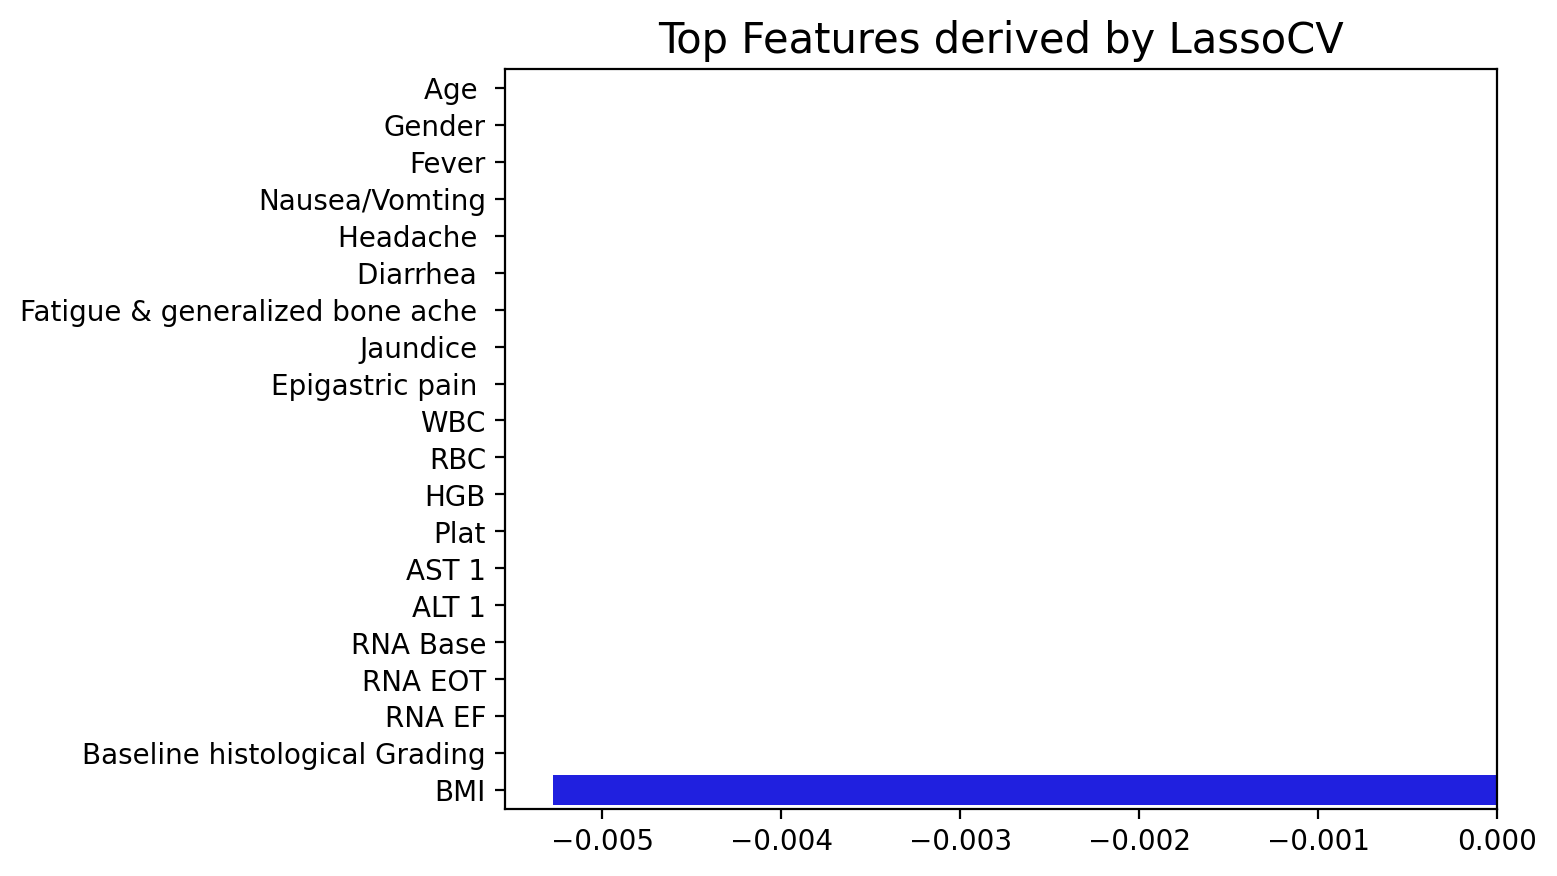

In [11]:
## to find significant features using LassoCV (all X_scaled)
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

print('Use LassoCV to find the optimal ALPHA value for L1 regularization')
# Scale the Predictors on both the train and validation set
std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
print('X_scaled', X_scaled.shape)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
# This is the best alpha value found
print('LASSO best alpha: ', lasso_model.alpha_ )

# display all coefficients in the model with optimal alpha
zipped = list(zip(X.columns, lasso_model.coef_))
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
print(zipped)
a,b = zip(*zipped)
sns.barplot(y=list(a), x=list(b), color='b')
plt.title('Top Features derived by LassoCV', size=15)

Text(0.5, 1.0, 'Top Features derived by Random Forest')

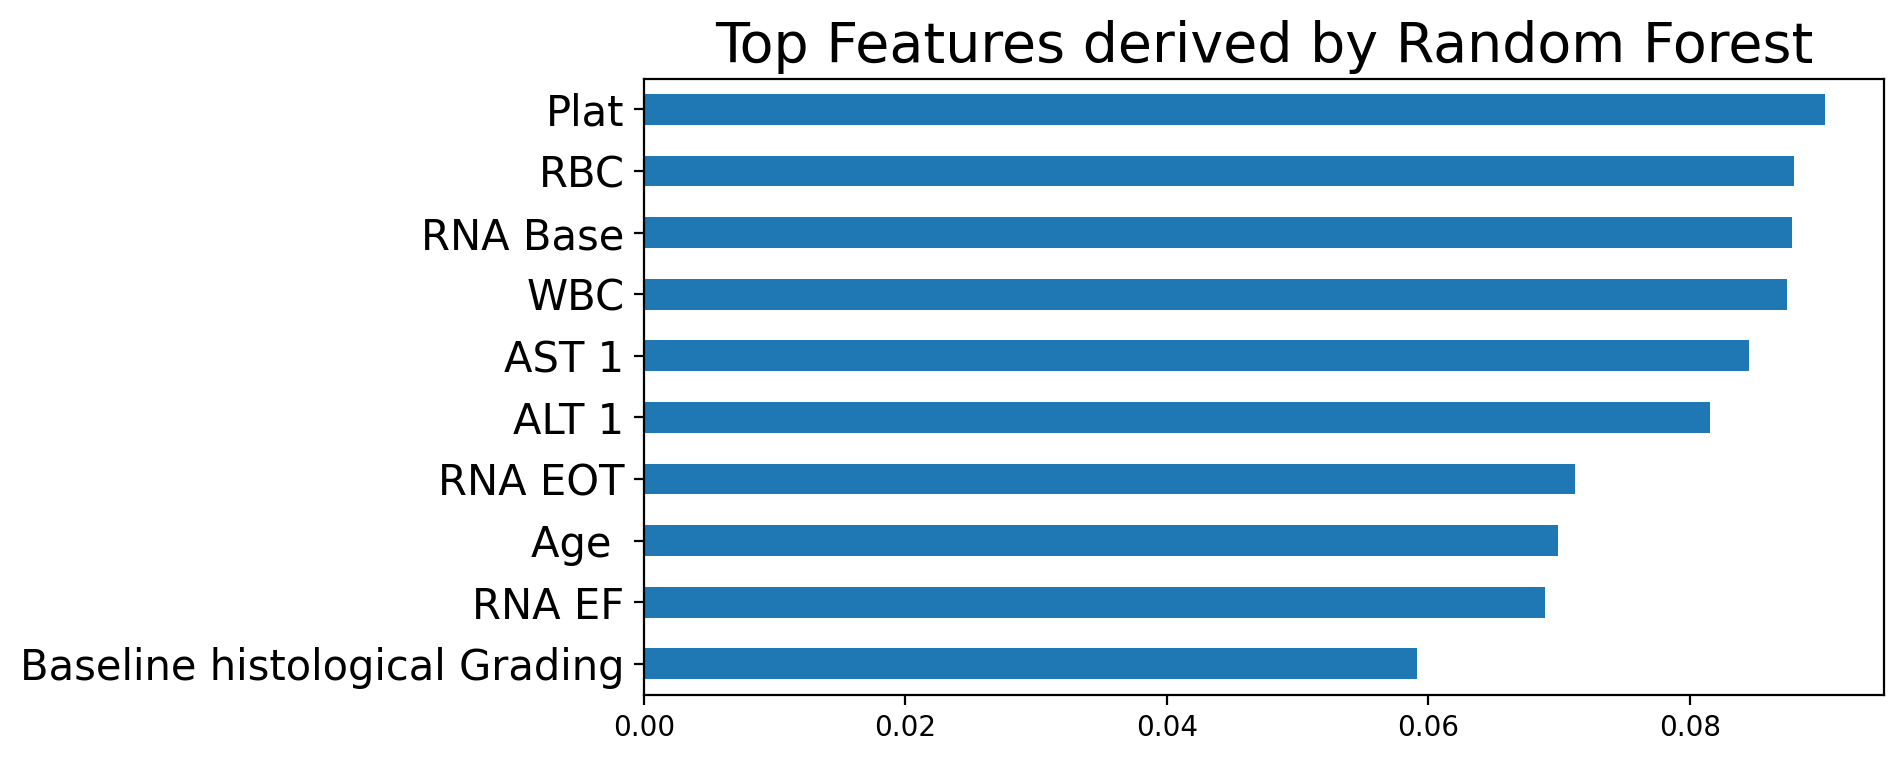

In [6]:
## To look for top features using Random Forest
# Create decision tree classifer object
rfc = RandomForestClassifier(random_state=SEED, n_estimators=100)

# Train model, note that NO scaling is required
rfc_model = rfc.fit(X, y)

# Plot the top features based on its importance
(pd.Series(rfc_model.feature_importances_, index=X.columns)
    .nlargest(10)   # can adjust based on how many top features you want
    .plot(kind='barh', figsize=[8,4])
    .invert_yaxis()) # Ensures that the feature with the most importance is on top, in descending order

plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=20)

In [7]:
# for linear data and model, p-value < 0.05 indicates a significant feature
import statsmodels.api as sm
X = sm.add_constant(X)  # need to add this to define the Intercept
# model / fit / summarize results
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Baselinehistologicalstaging   R-squared:                       0.020
Model:                                     OLS   Adj. R-squared:                  0.005
Method:                          Least Squares   F-statistic:                     1.381
Date:                         Thu, 26 Oct 2023   Prob (F-statistic):              0.121
Time:                                 19:08:00   Log-Likelihood:                -812.34
No. Observations:                         1385   AIC:                             1667.
Df Residuals:                             1364   BIC:                             1777.
Df Model:                                   20                                         
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.4479      0.243      1.840      0.066      -0.030       0.925
Age                                 -0.0022      0.001     -1.616      0.106      -0.005       0.000
Gender                              -0.0141      0.024     -0.597      0.550      -0.061       0.032
BMI                                 -0.0078      0.003     -2.675      0.008      -0.014      -0.002
Fever                               -0.0351      0.024     -1.485      0.138      -0.082       0.011
Nausea/Vomting                       0.0224      0.024      0.939      0.348      -0.024       0.069
Headache                             0.0032      0.024      0.136      0.892      -0.043       0.050
Diarrhea                             0.0053      0.024      0.222      0.824      -0.041       0.052
Fatigue & generalized bone ache      0.0181      0.024      0.767      0.443      -0.028       0.065
Jaundice                             0.0068      0.024      0.286      0.775      -0.040       0.053
Epigastric pain                     -0.0155      0.024     -0.650      0.516      -0.062       0.031
WBC                               5.739e-06   4.45e-06      1.291      0.197   -2.98e-06    1.45e-05
RBC                               2.607e-08   3.42e-08      0.763      0.445   -4.09e-08    9.31e-08
HGB                                  0.0063      0.007      0.909      0.364      -0.007       0.020
Plat                              -3.32e-07   3.07e-07     -1.082      0.280   -9.34e-07     2.7e-07
AST 1                               -0.0008      0.000     -1.691      0.091      -0.002       0.000
ALT 1                                0.0007      0.000      1.521      0.128      -0.000       0.002
RNA Base                          3.679e-08   3.34e-08      1.100      0.271   -2.88e-08    1.02e-07
RNA EOT                          -4.482e-08   5.01e-08     -0.894      0.371   -1.43e-07    5.35e-08
RNA EF                             4.52e-08   4.95e-08      0.913      0.361   -5.19e-08    1.42e-07
Baseline histological Grading       -0.0052      0.003     -1.764      0.078      -0.011       0.001
==============================================================================
Omnibus:                      289.340   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.769
Skew:                           1.052   Prob(JB):                     4.40e-64
Kurtosis:                       2.207   Cond. No.                     9.30e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correct

In [8]:
X = df.drop('Baselinehistologicalstaging', axis=1)   # axis=0 for row, axis=1 for column
y = df['Baselinehistologicalstaging']

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=SEED, stratify=y)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

# # Data preprocessing, Scaling Numerical columns
# from sklearn.preprocessing import MinMaxScaler, StandardScaler   # not much difference in results
# # scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range = (0,1))
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

X_train (1315, 20)
y_train (1315,)
X_test (70, 20)
y_test (70,)


In [9]:


## Baseline model performance evaluation
# kf = KFold(n_splits=5, shuffle=True, random_state=SEED)   # this may result in imbalance classes in each fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
# to give model baseline report in dataframe
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    logloss      = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [0]       })   # timetaken: to be used for comparison later
    return df_model

# to evaluate baseline models
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
svc = SVC()
linearsvc = LinearSVC()
mlp = MLPClassifier()

# to concat all models
df_models = pd.concat([baseline_report(gnb, X_train, X_test, y_train, y_test, 'GaussianNB'),
                       baseline_report(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB'),
                       baseline_report(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB'),
                       baseline_report(logit, X_train, X_test, y_train, y_test, 'LogisticRegression'),
                       baseline_report(knn, X_train, X_test, y_train, y_test, 'KNN'),
                       baseline_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree'),
                       baseline_report(randomforest, X_train, X_test, y_train, y_test, 'RandomForest'),
                       baseline_report(svc, X_train, X_test, y_train, y_test, 'SVC'),
                       baseline_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC'),
                       baseline_report(mlp, X_train, X_test, y_train, y_test, 'mlp'                )
                       ], axis=0).reset_index()
df_models = df_models.drop('index', axis=1)
df_models

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.738403,0.000000,0.000000,0.000000,0.514021,9.268368,0
1,BernoulliNB,0.738403,0.000000,0.000000,0.000000,0.500000,9.268368,0
2,MultinomialNB,0.517871,0.267975,0.485422,0.345213,0.506940,20.596373,0
3,LogisticRegression,0.738403,0.000000,0.000000,0.000000,0.503684,9.268368,0
4,KNN,0.676046,0.232008,0.107715,0.146491,0.503441,12.872733,0
5,DecisionTree,0.596958,0.280026,0.287639,0.279301,0.516686,13.902552,0
6,RandomForest,0.735361,0.000000,0.000000,0.011113,0.511527,10.298187,0
7,SVC,0.738403,0.000000,0.000000,0.000000,0.524727,9.268368,0
8,LinearSVC,0.643346,0.156654,0.600000,0.249398,0.494836,9.268368,0
9,mlp,0.601521,0.147160,0.313896,0.164443,0.485503,13.387643,0


In [10]:
def model_report(model, X_train, X_test, y_train, y_test, model_name):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value

    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1)
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11),
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21),
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            if th<0:
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display f1score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    accuracy      = model.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
#     y_pred = [1 if x==True else 0 if x==False else x for x in y_pred]   # .predict->0/1; .predict_proba->False/True
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict_proba(X_test)[:,1]   # use this at optimal th, for AUC and logloss
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(rocauc))
    logloss      = log_loss(y_test, y_pred)   # same result using y_pred = model.predict_proba(X_test)
    print(model_name, 'Log-loss: {:.4f}'.format(logloss))

    df_model = pd.DataFrame({'model'        : [model_name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [1000]       })   # timetaken for comparison later
    return df_model

In [11]:
print('\n"""""" GaussianNB """"""')
time1 = time.time()
gnb = GaussianNB()
model1 = model_report(gnb, X_train, X_test, y_train, y_test, 'GaussianNB')
model1.timetaken[0] = time.time() - time1


print('\n"""""" BernoulliNB """"""')
time1 = time.time()
bnb = BernoulliNB()
model2 = model_report(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB')
model2.timetaken[0] = time.time() - time1


print('\n"""""" MultinomialNB """"""')
time1 = time.time()
mnb = MultinomialNB()
model3 = model_report(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB')
model3.timetaken[0] = time.time() - time1


"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4091,  0.100->0.4091,  0.200->0.3953,  0.300->0.2667,  0.400->0.0000,  0.500->0.0000,  0.600->0.0000,  0.700->0.0000,  0.800->0.0000,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.000->0.4091,  0.010->0.4091,  0.020->0.4091,  0.030->0.4091,  0.040->0.4091,  0.050->0.4091,  0.060->0.4091,  0.070->0.4091,  0.080->0.4091,  0.090->0.4091,  0.100->0.4091,  
Looping decimal place 3
0.000->0.4091,  0.001->0.4091,  0.002->0.4091,  0.003->0.4091,  0.004->0.4091,  0.005->0.4091,  0.006->0.4091,  0.007->0.4091,  0.008->0.4091,  0.009->0.4091,  0.010->0.4091,  optimal F1 score = 0.4091
optimal threshold = 0.000
GaussianNB accuracy score is
Training: 73.84%
Test set: 74.29%

Adjust threshold to 0.25:
Precision: 0.2326,   Recall: 0.5556,   F1 Score: 0.3279
GaussianNB confusion matrix: 
 [[19 33]
 [ 8 10]]

Default threshold of 0.50:
Preci

In [12]:
print('\nLogisticRegression')
time1 = time.time()
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)
for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

logit = LogisticRegression(C = optimal_c)
model4 = model_report(logit, X_train, X_test, y_train, y_test, 'LogisticRegression')
model4.timetaken[0] = time.time() - time1


LogisticRegression

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [13]:
print('\n"""""" KNN """""" ')
time1 = time.time()
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

knn = KNeighborsClassifier(n_neighbors = optimal_k)
model5 = model_report(knn, X_train, X_test, y_train, y_test, 'KNN')
model5.timetaken[0] = time.time() - time1

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))


"""""" KNN """""" 

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.2551, 0.0962, 0.1782, 0.0762, 0.1730, 0.0724, 0.1147, 0.0613, 0.1156, 0.0669, 0.0904, 0.0478, 0.0505, 0.0324, 0.0723, 0.0282, 0.0525, 0.0332, 0.0432, 0.0163, optimal cv F1 score = 0.2551
optimal value of K = 1

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.1579,  0.100->0.1579,  0.200->0.1579,  0.300->0.1579,  0.400->0.1579,  0.500->0.1579,  0.600->0.1579,  0.700->0.1579,  0.800->0.1579,  0.900->0.1579,  1.000->0.1579,  
Looping decimal place 2
0.000->0.1579,  0.010->0.1579,  0.020->0.1579,  0.030->0.1579,  0.040->0.1579,  0.050->0.1579,  0.060->0.1579,  0.070->0.1579,  0.080->0.1579,  0.090->0.1579,  0.100->0.1579,  
Looping decimal place 3
0.000->0.1579,  0.001->0.1579,  0.002->0.1579,  0.003->0.1579,  0.004->0.1579,  0.005->0.1579,  0.006->0.1579,  0.007->0.1579,  0.008->0.15

In [14]:
print('\n"""""" DecisionTreeClassifier """"""')
time1 = time.time()
print('\nSearch for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, X_train, y_train, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model6 = model_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree')
model6.timetaken[0] = time.time() - time1
# Note: results keep changing in each run


"""""" DecisionTreeClassifier """"""

Search for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data
0.0153, 0.0463, 0.0968, 0.0910, 0.1212, 0.1490, 0.1814, 0.2279, 0.2247, optimal F1 score = 0.2279
optimal max_depth = 9

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.3797,  0.100->0.3934,  0.200->0.3729,  0.300->0.4500,  0.400->0.5161,  0.500->0.3333,  0.600->0.3333,  0.700->0.2609,  0.800->0.2609,  0.900->0.2609,  1.000->0.2609,  
Looping decimal place 2
0.300->0.4500,  0.310->0.4500,  0.320->0.4737,  0.330->0.4737,  0.340->0.4737,  0.350->0.5161,  0.360->0.5161,  0.370->0.5161,  0.380->0.5161,  0.390->0.5161,  0.400->0.5161,  0.410->0.5161,  0.420->0.5161,  0.430->0.5161,  0.440->0.5161,  0.450->0.3333,  0.460->0.3333,  0.470->0.3333,  0.480->0.3333,  0.490->0.3333,  0.500->0.3333,  
Looping decimal place 3
0.340->0.4737,  0.341->0.4737,  0.342->0.4737,  0.343->0.4

In [15]:
print('\n"""""" RandomForestClassifier """""" (quite slow)')
time1 = time.time()
print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

randomforest = RandomForestClassifier(n_estimators=optimal_n)
model7 = model_report(randomforest, X_train, X_test, y_train, y_test, 'RandomForest')
model7.timetaken[0] = time.time() - time1
# Note: results keep changing in each run


"""""" RandomForestClassifier """""" (quite slow)

Search for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data
100->0.0056, 150->0.0000, 200->0.0059, 250->0.0059, 300->0.0058, 350->0.0000, 400->0.0000, 450->0.0000, 500->0.0060, optimal F1 score = 0.0060
optimal n_estimators = 500

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4091,  0.100->0.4091,  0.200->0.3797,  0.300->0.1818,  0.400->0.0000,  0.500->0.0000,  0.600->0.0000,  0.700->0.0000,  0.800->0.0000,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.000->0.4091,  0.010->0.4091,  0.020->0.4091,  0.030->0.4091,  0.040->0.4091,  0.050->0.4091,  0.060->0.4091,  0.070->0.4091,  0.080->0.4091,  0.090->0.4091,  0.100->0.4091,  
Looping decimal place 3
0.000->0.4091,  0.001->0.4091,  0.002->0.4091,  0.003->0.4091,  0.004->0.4091,  0.005->0.4091,  0.006->0.4091,  0.007->0.4091,  0.008->0.4091,  0.009

In [16]:
print('\n"""""" SVC """"""')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model8 = model_report(svc, X_train, X_test, y_train, y_test, 'SVC')
model8.timetaken[0] = time.time() - time1


"""""" SVC """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4091,  0.100->0.4091,  0.200->0.4091,  0.300->0.0000,  0.400->0.0000,  0.500->0.0000,  0.600->0.0000,  0.700->0.0000,  0.800->0.0000,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.000->0.4091,  0.010->0.4091,  0.020->0.4091,  0.030->0.4091,  0.040->0.4091,  0.050->0.4091,  0.060->0.4091,  0.070->0.4091,  0.080->0.4091,  0.090->0.4091,  0.100->0.4091,  
Looping decimal place 3
0.000->0.4091,  0.001->0.4091,  0.002->0.4091,  0.003->0.4091,  0.004->0.4091,  0.005->0.4091,  0.006->0.4091,  0.007->0.4091,  0.008->0.4091,  0.009->0.4091,  0.010->0.4091,  optimal F1 score = 0.4091
optimal threshold = 0.000
SVC accuracy score is
Training: 73.84%
Test set: 74.29%

Adjust threshold to 0.25:
Precision: 0.2540,   Recall: 0.8889,   F1 Score: 0.3951
SVC confusion matrix: 
 [[ 5 47]
 [ 2 16]]

Default threshold of 0.50:
Precision: 0.0000,   Recal

In [17]:
print('\n"""""" LinearSVC """"""')
time1 = time.time()
linearsvc = LinearSVC()
# model9 = model_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')   # model has no attribute 'predict_proba'

linearsvc.fit(X_train, y_train)
print('LinearSVC accuracy score is')
print('Training: {:.2f}%'.format(100*linearsvc.score(X_train, y_train)))  # score uses accuracy
accuracy      = linearsvc.score(X_test, y_test)
print('Test set: {:.2f}%'.format(100*accuracy))

y_pred = linearsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print('LinearSVC confusion matrix: \n', confusion_matrix(y_test, y_pred))

precision    = precision_score(y_test, y_pred)
recall       = recall_score(y_test, y_pred)
f1score      = f1_score(y_test, y_pred)
rocauc       = roc_auc_score(y_test, y_pred)
logloss      = log_loss(y_test, y_pred)
print('LinearSVC AUC: {:.4f}'.format(rocauc))
print('LinearSVC Log-loss: {:.4f}'.format(logloss))

model9 = pd.DataFrame({'model'        : ['LinearSVC'],
                       'accuracy'     : [accuracy],
                       'precision'    : [precision],
                       'recall'       : [recall],
                       'f1score'      : [f1score],
                       'rocauc'       : [rocauc],
                       'logloss'      : [logloss],
                       'timetaken'    : [time.time() - time1]       })
# Note: results keep changing in each run


"""""" LinearSVC """"""
LinearSVC accuracy score is
Training: 73.84%
Test set: 74.29%
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        52
           1       0.00      0.00      0.00        18

    accuracy                           0.74        70
   macro avg       0.37      0.50      0.43        70
weighted avg       0.55      0.74      0.63        70

LinearSVC confusion matrix: 
 [[52  0]
 [18  0]]
LinearSVC AUC: 0.5000
LinearSVC Log-loss: 9.2684


In [ ]:
print('\n"""""" MLP""""""')
time1 = time.time()
mlp = MLPClassifier()
# model9 = model_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')   # model has no attribute 'predict_proba'

mlp.fit(X_train, y_train)
print('mlp accuracy score is')
print('Training: {:.2f}%'.format(100*mlp.score(X_train, y_train)))  # score uses accuracy
accuracy      = mlp.score(X_test, y_test)
print('Test set: {:.2f}%'.format(100*accuracy))

y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))
print('mlp confusion matrix: \n', confusion_matrix(y_test, y_pred))

precision    = precision_score(y_test, y_pred)
recall       = recall_score(y_test, y_pred)
f1score      = f1_score(y_test, y_pred)
rocauc       = roc_auc_score(y_test, y_pred)
logloss      = log_loss(y_test, y_pred)
print('MLP AUC: {:.4f}'.format(rocauc))
print('MLP Log-loss: {:.4f}'.format(logloss))

model10 = pd.DataFrame({'model'        : ['MLP'],
                       'accuracy'     : [accuracy],
                       'precision'    : [precision],
                       'recall'       : [recall],
                       'f1score'      : [f1score],
                       'rocauc'       : [rocauc],
                       'logloss'      : [logloss],
                       'timetaken'    : [time.time() - time1]       })
# Note: results keep changing in each run


"""""" MLP""""""
mlp accuracy score is
Training: 26.92%
Test set: 27.14%
              precision    recall  f1-score   support

           0       1.00      0.02      0.04        52
           1       0.26      1.00      0.41        18

    accuracy                           0.27        70
   macro avg       0.63      0.51      0.23        70
weighted avg       0.81      0.27      0.13        70

mlp confusion matrix: 
 [[ 1 51]
 [ 0 18]]
MLP AUC: 0.5096
MLP Log-loss: 25.1645


In [ ]:
# concat all models
df_models_tuned = pd.concat([model1,model2,model3,model4,model5,model6,model7,model8,model9,model10],axis = 0).reset_index()
df_models_tuned.drop('index', axis=1, inplace=True)
df_models_tuned

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.742857,0.257143,1.000000,0.409091,0.466880,0.577830,0.000000
1,BernoulliNB,0.742857,0.257143,1.000000,0.409091,0.500000,0.570066,0.000000
2,MultinomialNB,0.428571,0.210526,0.444444,0.285714,0.439637,19.736786,0.000000
3,LogisticRegression,0.742857,0.257143,1.000000,0.409091,0.389957,0.584416,38.000000
4,KNN,0.542857,0.150000,0.166667,0.157895,0.419872,15.789349,2.000000
5,DecisionTree,0.814286,0.642857,0.500000,0.562500,0.659722,2.827262,0.000000
6,RandomForest,0.728571,0.281250,1.000000,0.439024,0.450321,0.590100,52.000000
7,SVC,0.742857,0.257143,1.000000,0.409091,0.536325,0.568539,0.000000
8,LinearSVC,0.742857,0.000000,0.000000,0.000000,0.500000,8.881400,0.154637
9,MLP,0.271429,0.260870,1.000000,0.413793,0.509615,25.164548,1.390275


In [ ]:
df_models   # compare with baseline results before tuning

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.738403,0.000000,0.000000,0.000000,0.514021,8.881400,0
1,BernoulliNB,0.738403,0.000000,0.000000,0.000000,0.500000,8.881400,0
2,MultinomialNB,0.517871,0.267975,0.485422,0.345213,0.506940,19.736786,0
3,LogisticRegression,0.738403,0.000000,0.000000,0.000000,0.503684,8.881400,0
4,KNN,0.676046,0.232008,0.107715,0.146491,0.503441,12.335380,0
5,DecisionTree,0.614449,0.261225,0.284868,0.270866,0.509572,12.828837,0
6,RandomForest,0.736122,0.300000,0.000000,0.005714,0.487980,9.868245,0
7,SVC,0.738403,0.000000,0.000000,0.000000,0.524727,8.881400,0
8,LinearSVC,0.546768,0.104183,0.000000,0.083133,0.512982,25.657971,0
9,mlp,0.673764,0.094822,0.394203,0.071739,0.509450,8.881400,0


In [ ]:
# initialise an empty df for comparison: 1 = improved, 0 = no improvement
df1 = pd.DataFrame({'model': [0]*10,'accuracy': [0]*10,'precision': [0]*10,'recall': [0]*10,'f1score': [0]*10,'rocauc': [0]*10,'logloss': [0]*10,'timetaken': [0]*10})
df1.model = df_models.model
for i in range(1,6):
    for j in range(10):
        if df_models_tuned[df_models_tuned.columns[i]][j] > df_models[df_models.columns[i]][j]:
            df1[df1.columns[i]][j] = 1
for i in range(6,8):
    for j in range(10):
        if df_models_tuned[df_models_tuned.columns[i]][j] < df_models[df_models.columns[i]][j]:
            df1[df1.columns[i]][j] = 1
df1   # Note: F1-Score has improved for all models after tuning the threshold and other hyperparameters

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,1,1,1,1,0,1,0
1,BernoulliNB,1,1,1,1,0,1,0
2,MultinomialNB,0,0,0,0,0,0,0
3,LogisticRegression,1,1,1,1,0,1,0
4,KNN,0,0,1,1,0,0,0
5,DecisionTree,1,1,1,1,1,1,0
6,RandomForest,0,1,1,1,0,1,0
7,SVC,1,1,1,1,1,1,0
8,LinearSVC,1,0,0,0,1,0,0
9,mlp,1,0,0,0,0,1,0


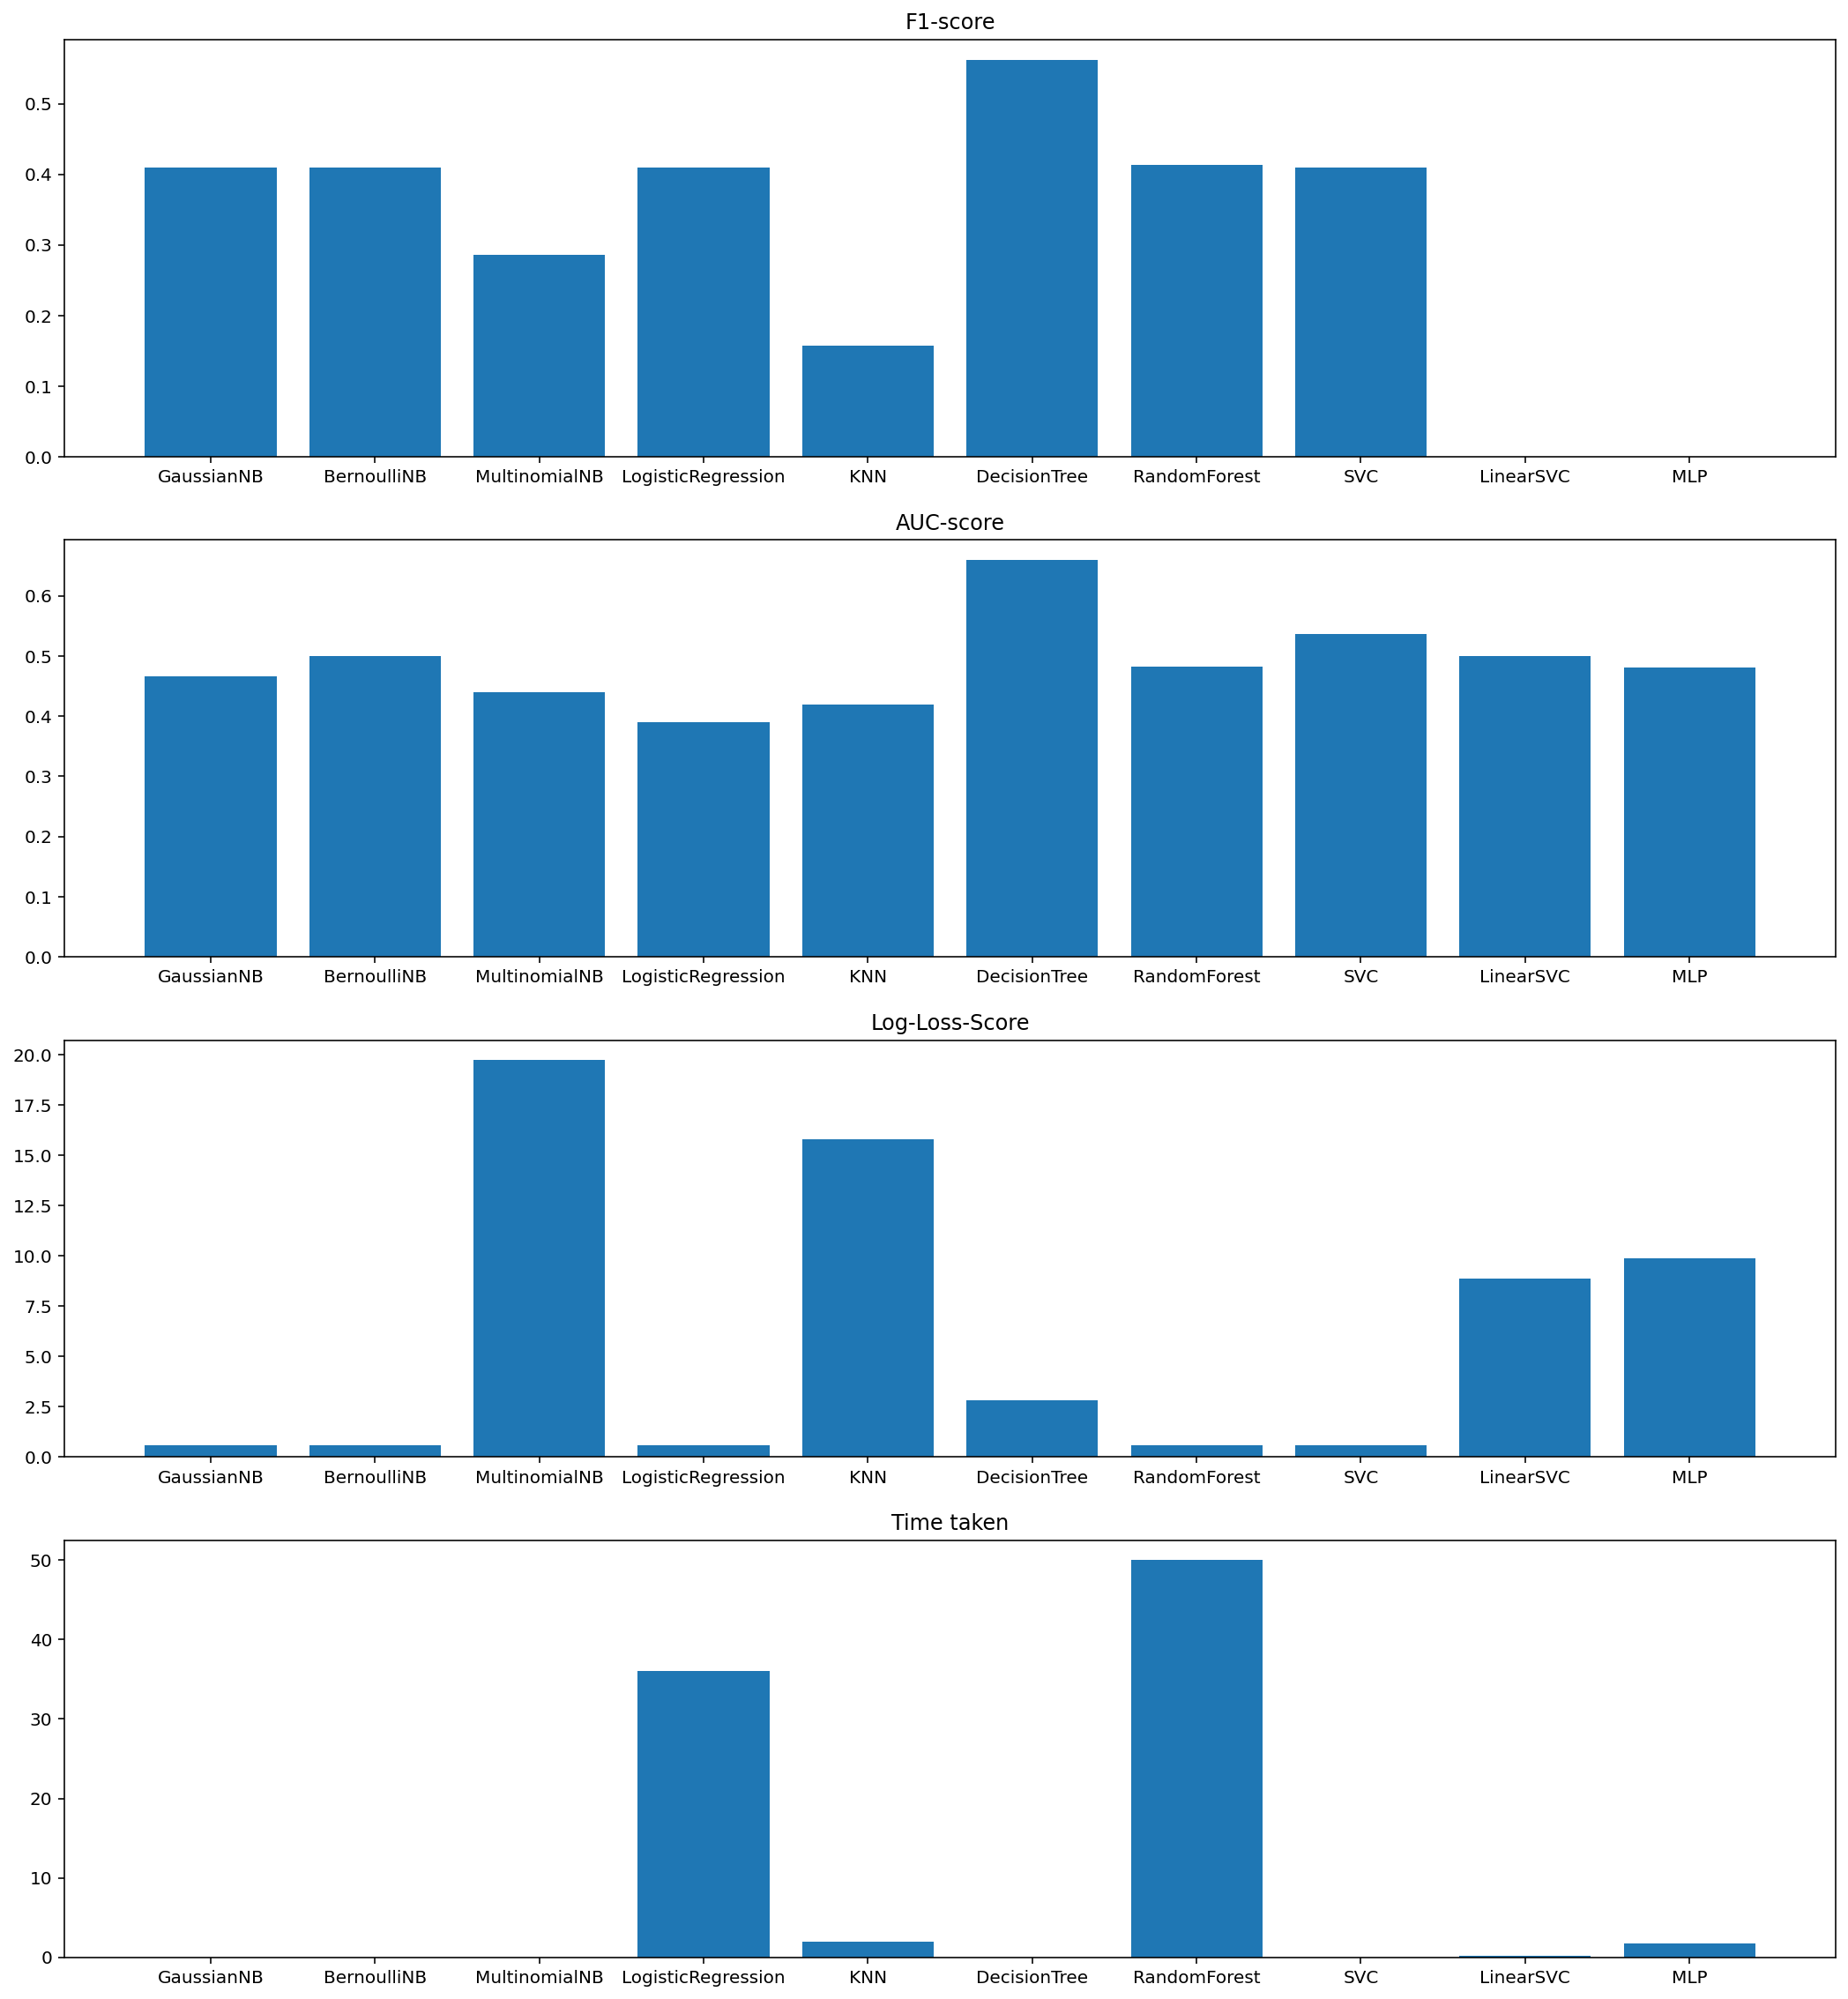

In [ ]:
## plot the performance metric scores
fig, ax = plt.subplots(4, 1, figsize=(18, 20))

ax[0].bar(df_models_tuned.model, df_models_tuned.f1score)
ax[0].set_title('F1-score')

ax[1].bar(df_models_tuned.model, df_models_tuned.rocauc)
ax[1].set_title('AUC-score')

ax[2].bar(df_models_tuned.model, df_models_tuned.logloss)
ax[2].set_title('Log-Loss-Score')

ax[3].bar(df_models_tuned.model, df_models_tuned.timetaken)
ax[3].set_title('Time taken')

# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

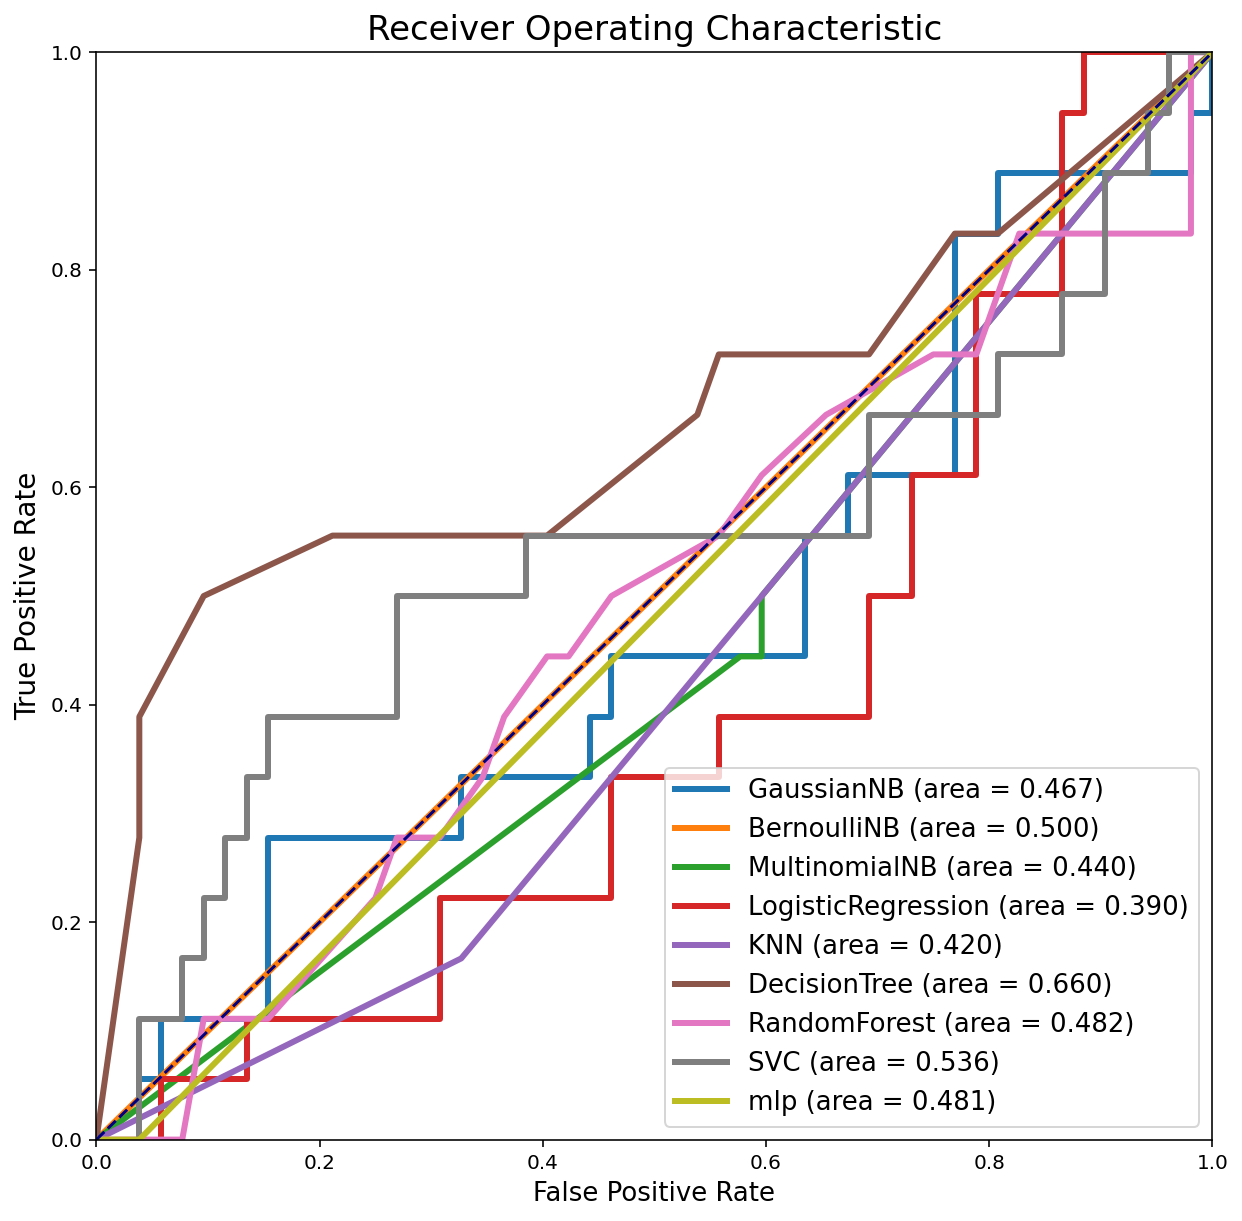

In [ ]:
# plot the ROC curves
plt.figure(figsize=(10,10))

model_name = [gnb, bnb, mnb, logit, knn, decisiontree, randomforest, svc, linearsvc]

for i in range(8):
    y_pred = model_name[i].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, lw=3, label=df_models_tuned.model[i] + ' (area = %0.3f)' % auc(fpr, tpr))

y_pred = mlp.predict(X_test)   # linearsvc has no attribute 'predict_proba'
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=3, label='mlp (area = %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()